# Machine Learning in Python - Project 1

Due Friday, March 8th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup

*Install any packages here and load data*

In [16]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold

In [3]:
# Load data in easyshare.csv
df = pd.read_csv("easyshare.csv")
df.head()

,mergeid,int_year,wave,country,country_mod,female,age,birth_country,citizenship,isced1997_r,...,bmi2,smoking,ever_smoked,br010_mod,br015_,casp,chronic_mod,sp008_,ch001_,cogscore
0,AT-000674-01,2011.0,4.0,11.0,40.0,1.0,59.700001,40.0,40.0,5.0,...,2.0,5.0,5.0,5.0,1.0,44.0,1.0,5.0,2.0,8.0
1,AT-001215-01,2011.0,4.0,11.0,40.0,1.0,72.599998,528.0,528.0,5.0,...,3.0,1.0,1.0,2.0,1.0,35.0,6.0,1.0,0.0,14.5
2,AT-001492-01,2011.0,4.0,11.0,40.0,1.0,59.599998,40.0,40.0,3.0,...,2.0,5.0,1.0,7.0,2.0,43.0,1.0,5.0,6.0,18.5
3,AT-001492-02,2011.0,4.0,11.0,40.0,0.0,59.799999,40.0,40.0,4.0,...,2.0,1.0,1.0,7.0,3.0,47.0,1.0,NaN,6.0,24.0
4,AT-001816-01,2004.0,1.0,11.0,40.0,1.0,61.299999,40.0,40.0,3.0,...,2.0,5.0,1.0,4.0,3.0,43.0,0.0,5.0,2.0,20.0


In [15]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])


def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return Metrics

# Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a professional body (e.g. European Union, Governments, Health Institutes and/or Charities on dementia and ageing). If you use any additional data sources, you should introduce them here and discuss why they were included.*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

# Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.*

*You should also split your data into training and testing sets, ideally before you look to much into the features and relationships with the target*

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. Feature engineering that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*If you decide to extract additional features from the full data (easyshare_all.csv), describe these variables here.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

In [12]:
# Drop the null values
df = df.dropna()

# We have no duplicated values :)
df.duplicated().sum()

df.info()

# this looks horrid due to the number of features
# sns.pairplot(df)

<class 'pandas.core.frame.DataFrame'>
Index: 47515 entries, 0 to 97504
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mergeid        47515 non-null  object 
 1   int_year       47515 non-null  float64
 2   wave           47515 non-null  float64
 3   country        47515 non-null  float64
 4   country_mod    47515 non-null  float64
 5   female         47515 non-null  float64
 6   age            47515 non-null  float64
 7   birth_country  47515 non-null  float64
 8   citizenship    47515 non-null  float64
 9   isced1997_r    47515 non-null  float64
 10  eduyears_mod   47515 non-null  float64
 11  eurod          47515 non-null  float64
 12  bmi            47515 non-null  float64
 13  bmi2           47515 non-null  float64
 14  smoking        47515 non-null  float64
 15  ever_smoked    47515 non-null  float64
 16  br010_mod      47515 non-null  float64
 17  br015_         47515 non-null  float64
 18  casp       

In [22]:
from sklearn.model_selection import train_test_split

rng = np.random.seed(21701)

# First split off features and targets
X = df.drop(['mergeid', 'cogscore'], axis = 1) # Set of features
y = df['cogscore']

# We shuffle the data so the countries get mixed up
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rng)

# Do we want to do 80-20-20 to include a validation set? 
# Alternatively, we do CV in the end which may be better
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

# print("X_val:", X_val.shape)
# print("y_val:", y_val.shape)

X_train: (33260, 21)
y_train: (33260,)
X_test: (14255, 21)
y_test: (14255,)


[['intercept' 490.4747]
 ['int_year' -0.2373]
 ['wave' 0.7872]
 ['country' -0.0173]
 ['country_mod' -0.0001]
 ['female' 0.8294]
 ['age' -0.1191]
 ['birth_country' -0.0002]
 ['citizenship' -0.0008]
 ['isced1997_r' 0.6749]
 ['eduyears_mod' 0.0942]
 ['eurod' -0.1841]
 ['bmi' 0.0092]
 ['bmi2' 0.014]
 ['smoking' 0.058]
 ['ever_smoked' -0.0549]
 ['br010_mod' 0.0684]
 ['br015_' -0.162]
 ['casp' 0.0658]
 ['chronic_mod' 0.0038]
 ['sp008_' -0.1098]
 ['ch001_' -0.0271]]


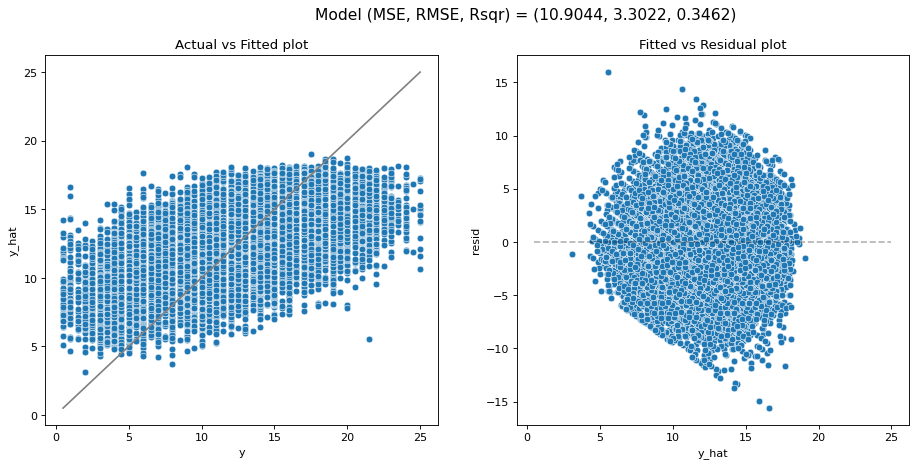

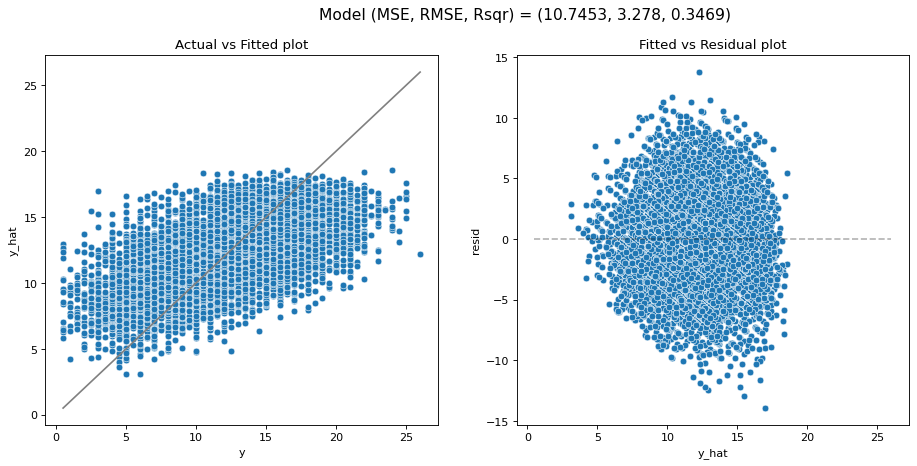

(10.7453, 3.278, 0.3469)

In [19]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression().fit(X_train, y_train)

print(np.c_[np.append(['intercept'],lm.feature_names_in_),np.round(get_coefs(lm),4)])

# Model fit on training data
model_fit(lm, X_train, y_train, plot = True)

# Model fit on test data
model_fit(lm, X_test, y_test, plot = True)

# Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. linear regression, interaction terms, lasso, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validating it.*

*For example if you considered a linear regression model, a polynomial regression, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide comparison of your model with baseline model(s) on the test data but only briefly describe the baseline model(s) considered*

# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a government official or charity directy, who is understands the pressing challenges associated with ageining and dementia but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also mention potential limitations of your model.*

*Finally, you should include recommendations on potential lifestyle changes or governmental/societal interventions to reduce dementia risk.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# References

*Include references if any*

In [ ]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project1.ipynb